# Pretrained ImageNet Classifier with fastai v1

- Author: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou)
- Date: January 2019
- Source: https://discuss.pytorch.org/t/pretrained-resnet-constant-output/2760

## Objective

The objective here is to use [fastai v1](https://docs.fast.ai/index.html) instead of Pytorch code in order to classify images into 1000 classes by using an ImageNet winner model.

## Initialisation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.widgets import *

In [3]:
from io import BytesIO

In [4]:
import fastai
print(fastai.__version__)

1.0.42


## Model

Let's use resnet34.

In [5]:
# Get weights of the model, build the model and put it into eval mode
model = models.resnet34(pretrained=True, num_classes=1000)
model = nn.Sequential(model, nn.LogSoftmax(dim=1))
model = model.eval()

In [6]:
# Get ImageNet classes
url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/' \
      'raw/596b27d23537e5a1b5751d2b0481ef172f58b539/imagenet1000_clsid_to_human.txt'
imagenet_classes = eval(requests.get(url).content)

In [7]:
# Transformation to apply to image before prediction (center crop)
tfms = [crop_pad()]

## Data to classify

In [8]:
# List of images to classify
images = [('cat', 'https://www.readersdigest.ca/wp-content/uploads/sites/14/2011/01/4-ways-cheer-up-depressed-cat.jpg'),
          ('dog', 'https://c.photoshelter.com/img-get/I0000q_DdkyvP6Xo/s/900/900/Pomeranian-Dog-with-Ball.jpg'),
          ('wine', 'https://www.thetimes.co.uk/imageserver/image/methode%2Fsundaytimes%2Fprod%2Fweb%2Fbin%2F5e7dc0d2-9b24-11e8-9837-8c5d4fba4ce3.jpg?crop=2667%2C1500%2C0%2C0&resize=685')]

## Get prediction

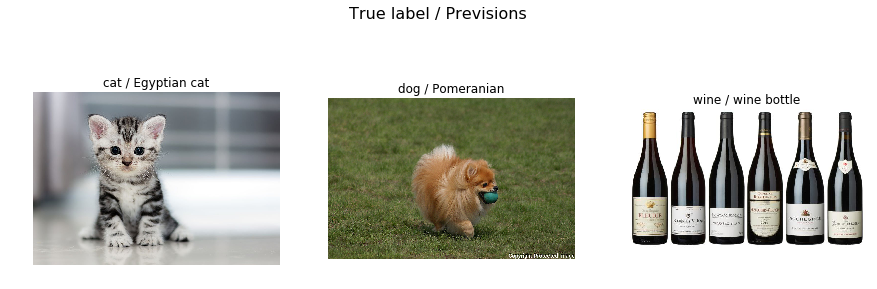

In [9]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
fig.suptitle('True label / Previsions', fontsize=16)

for i, image in enumerate(images):
    
    # Get image
    class_name, img_url = image[0], image[1]
    response = requests.get(img_url)
    img = open_image(BytesIO(response.content))
    
    # apply crop_pad + resize to 224 + normalisation 
    img_tfms = normalize(img.apply_tfms(tfms, size=224).data, *tensor(imagenet_stats))
    
    # Get prediction
    img_tfms = img_tfms.view(1, 3, 224, 224)
    preds = model(img_tfms).data.cpu().numpy()
    num_class = np.argmax(preds)
    
    img.show(ax=ax[i], title=f'{class_name} / {imagenet_classes[num_class]}')